In [ ]:
!pip install recommenders surprise cornac==2.3.0 ranx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.4/25.4 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.4 MB/s et

In [ ]:
!add-apt-repository ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install --only-upgrade libstdc++6

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntu-toolchain-r/test/ubuntu/ jammy main'
Description:
Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Adding repository.
Press [ENTER] to continue or Ctrl-c to cancel.
Adding deb entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntu-toolchain-r-ubuntu-test.gpg with fingerprint C8EC952E2A0E1FBDC5090F6A2C277A0A352154E5
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,

## Preparation

In [1]:
import pickle
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import numpy as np
import cornac

from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_chrono_split

from recommenders.models.cornac.cornac_utils import predict_ranking
from ranx import Qrels, Run, evaluate

from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools

sns.set_style('whitegrid')

In [190]:
PATH_TO_PROCESSED_DATA = '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/data_robustness_test/'

In [4]:
book_rating_filtered = pd.read_csv('/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/goodbooks-10k/data_sample_split/all_filtered_data.txt', sep="\t")

In [5]:
book_rating_filtered["time"] = pd.to_datetime(book_rating_filtered["time"])

In [6]:
def calculate_sparsity(user_item_matrix):
  matrix = user_item_matrix.pivot_table(index='user_id', columns='book_id', values='rating', fill_value=0)
  sparse_matrix = csr_matrix(matrix.values)

  total_possible = matrix.shape[0] * matrix.shape[1]

  nonzero_count = sparse_matrix.count_nonzero()

  sparsity = 1 - (nonzero_count / total_possible)
  return sparsity

In [7]:
len(book_rating_filtered)

578237

In [8]:
calculate_sparsity(book_rating_filtered)

0.9421763

## Sampling

### Sparsity > 95%

In [135]:
unique_user_id = book_rating_filtered['user_id'].unique()
len(unique_user_id)

10000

In [136]:
count_book_read_user = book_rating_filtered.groupby('user_id').agg({'book_id':'nunique', 'rating':'mean'})
count_book_read_user[["book_id"]].describe().T

,count,mean,std,min,25%,50%,75%,max
book_id,10000.0,57.8237,21.853791,20.0,41.0,56.0,72.0,158.0


In [137]:
count_user_in_book = book_rating_filtered.groupby('book_id').agg({'user_id':'nunique', 'rating':'mean'})
count_user_in_book[["user_id"]].describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1000.0,578.237,530.405546,153.0,272.0,389.5,637.25,4400.0


In [138]:
user_less_50 = count_book_read_user[count_book_read_user.book_id < 50].index

In [13]:
len(user_less_50)

3910

In [139]:
sample_1000_user = np.random.choice(user_less_50, 1000, replace=False)

In [140]:
sample_book1 = book_rating_filtered[book_rating_filtered.user_id.isin(sample_1000_user)]

In [141]:
calculate_sparsity(sample_book1)

0.963257

In [142]:
sample_book1

,user_id,book_id,rating,time
223,70,323,5,2024-01-01 00:00:00
224,70,26,4,2024-01-01 00:01:00
225,70,80,5,2024-01-01 00:02:00
226,70,709,5,2024-01-01 00:05:00
227,70,597,5,2024-01-01 00:14:00
...,...,...,...,...
578154,43975,710,4,2024-01-01 01:24:00
578155,43975,42,5,2024-01-01 01:25:00
578156,43975,437,5,2024-01-01 01:26:00
578159,51375,658,3,2024-01-01 01:21:00


In [143]:
data_train1, data_test1 = python_chrono_split(
    sample_book1, ratio=0.80, filter_by="user",
    col_user="user_id", col_item="book_id", col_timestamp="time"
)

In [144]:
len(sample_book1), len(data_train1), len(data_test1)

(36743, 29386, 7357)

In [167]:
sample_book1.to_csv(PATH_TO_PROCESSED_DATA + 'all_data_sparse_96.tsv', sep='\t', index=False)
data_train1.to_csv(PATH_TO_PROCESSED_DATA + 'train_sparse_96.tsv', sep='\t', index=False)
data_test1.to_csv(PATH_TO_PROCESSED_DATA + 'test_sparse_96.tsv', sep='\t', index=False)

### Sparsity ~75%

In [158]:
top_50_books = count_user_in_book.sort_values('user_id', ascending=False).index[:50]

In [159]:
rating_book_top50 = book_rating_filtered[book_rating_filtered.book_id.isin(top_50_books)]

In [160]:
unique_user_top50 = rating_book_top50['user_id'].unique()

In [161]:
sample_1000_user = np.random.choice(unique_user_top50, 1000, replace=False)

In [162]:
sample_book2 = rating_book_top50[rating_book_top50.user_id.isin(sample_1000_user)]

In [163]:
calculate_sparsity(sample_book2)

0.7484999999999999

In [164]:
data_train2, data_test2 = python_chrono_split(
    sample_book2, ratio=0.80, filter_by="user",
    col_user="user_id", col_item="book_id", col_timestamp="time"
)

In [165]:
len(sample_book2), len(data_train2), len(data_test2)

(12575, 10049, 2526)

In [168]:
sample_book2.to_csv(PATH_TO_PROCESSED_DATA + 'all_data_sparse_75.tsv', sep='\t', index=False)
data_train2.to_csv(PATH_TO_PROCESSED_DATA + 'train_sparse_75.tsv', sep='\t', index=False)
data_test2.to_csv(PATH_TO_PROCESSED_DATA + 'test_sparse_75.tsv', sep='\t', index=False)

### Sparsity ~50%

In [169]:
count_book_read_user = rating_book_top50.groupby('user_id').agg({'book_id':'nunique', 'rating':'mean'})
count_book_read_user[["book_id"]].describe().T

,count,mean,std,min,25%,50%,75%,max
book_id,9853.0,12.297879,7.151149,1.0,7.0,11.0,17.0,41.0


In [170]:
user_read_more_20 = count_book_read_user[count_book_read_user.book_id > 20].index

In [84]:
len(user_read_more_20)

1364

In [174]:
sample_1000_user = np.random.choice(user_read_more_20, 1000, replace=False)

In [175]:
sample_book3 = rating_book_top50[rating_book_top50.user_id.isin(sample_1000_user)]

In [176]:
calculate_sparsity(sample_book3)

0.5001

In [177]:
data_train3, data_test3 = python_chrono_split(
    sample_book3, ratio=0.80, filter_by="user",
    col_user="user_id", col_item="book_id", col_timestamp="time"
)

In [178]:
len(sample_book3), len(data_train3), len(data_test3)

(24995, 20026, 4969)

In [179]:
sample_book3.to_csv(PATH_TO_PROCESSED_DATA + 'all_data_sparse_50.tsv', sep='\t', index=False)
data_train3.to_csv(PATH_TO_PROCESSED_DATA + 'train_sparse_50.tsv', sep='\t', index=False)
data_test3.to_csv(PATH_TO_PROCESSED_DATA + 'test_sparse_50.tsv', sep='\t', index=False)

## Sparsity Experiment

In [180]:
SEED = 100

In [184]:
def run_bpr(train_data, test_data):
  eval_method = cornac.eval_methods.BaseMethod.from_splits(
    train_data=list(train_data[['user_id', 'book_id', 'rating']].itertuples(index=False)),
    test_data=list(test_data[['user_id', 'book_id', 'rating']].itertuples(index=False)),
    exclude_unknowns=False,
    verbose=False,
    seed=SEED,
    )

  bpr = cornac.models.BPR(
    k=180,
    max_iter=150,
    learning_rate=0.0672,
    lambda_reg=0.0013,
    verbose=True,
    seed=SEED
  )

  print("Training.....")
  with Timer() as t:
    bpr.fit(eval_method.train_set)
  print("Took {} seconds for training.".format(t))

  print("Predicting....")
  with Timer() as t:
    all_predictions_bpr = predict_ranking(bpr, train_data, usercol='user_id', itemcol='book_id', remove_seen=True)
  print("Took {} seconds for prediction.".format(t))

  test_data['user_id'] = test_data['user_id'].astype(str)
  test_data['book_id'] = test_data['book_id'].astype(str)
  all_predictions_bpr['user_id'] = all_predictions_bpr['user_id'].astype(str)
  all_predictions_bpr['book_id'] = all_predictions_bpr['book_id'].astype(str)

  print("Evaluating....")

  qrels = Qrels.from_df(
    df=test_data,
    q_id_col="user_id",
    doc_id_col="book_id",
    score_col="rating",
  )

  run_bpr = Run.from_df(
    df=all_predictions_bpr,
    q_id_col="user_id",
    doc_id_col="book_id",
    score_col="prediction",
  )

  return evaluate(qrels, run_bpr, ["mrr", "ndcg@10", "recall@10", "precision@10", "hit_rate@10"], make_comparable=True)


In [185]:
bpr_metrics = []

In [186]:
for data_train, data_test in zip([data_train1, data_train2, data_train3],[data_test1, data_test2, data_test3]):
  bpr_metrics.append(run_bpr(data_train, data_test))

Training.....


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Took 4.2217 seconds for training.
Predicting....
Took 6.4828 seconds for prediction.
Evaluating....
Training.....


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Took 0.7370 seconds for training.
Predicting....
Took 0.2497 seconds for prediction.
Evaluating....
Training.....


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!
Took 2.0369 seconds for training.
Predicting....
Took 0.1668 seconds for prediction.
Evaluating....


In [187]:
pd.DataFrame(bpr_metrics)

,mrr,ndcg@10,recall@10,precision@10,hit_rate@10
0,0.031964,0.006812,0.008246,0.005900,0.057000
1,0.158268,0.113240,0.196656,0.053326,0.432946
2,0.550604,0.394917,0.470968,0.233000,0.942000


In [314]:
def ranking_eval(
    model,
    train_set,
    test_set,
    exclude_unknowns=True,
    mode="last",
    verbose=False,
):

    rankings = []
    scores = []
    user_sessions = defaultdict(list)
    session_ids = []
    for [sid], [mapped_ids], [session_items] in tqdm(
        test_set.si_iter(batch_size=1, shuffle=False),
        total=len(test_set.sessions)):

        # if len(session_items) < 2:  # exclude all session with size smaller than 2
        #     continue
        user_idx = test_set.uir_tuple[0][mapped_ids[0]]
        session_ids.append(sid)

        start_pos = 1 if mode == "next" else len(session_items) - 1
        for test_pos in range(start_pos, len(session_items), 1):
            test_pos_items = session_items[test_pos]

            # binary mask for ground-truth positive items
            u_gt_pos_mask = np.zeros(test_set.num_items, dtype="int")
            u_gt_pos_mask[test_pos_items] = 1

            # binary mask for ground-truth negative items, removing all positive items
            u_gt_neg_mask = np.ones(test_set.num_items, dtype="int")
            u_gt_neg_mask[test_pos_items] = 0

            # filter items being considered for evaluation
            if exclude_unknowns:
                u_gt_pos_mask = u_gt_pos_mask[: train_set.num_items]
                u_gt_neg_mask = u_gt_neg_mask[: train_set.num_items]

            u_gt_pos_items = np.nonzero(u_gt_pos_mask)[0]
            u_gt_neg_items = np.nonzero(u_gt_neg_mask)[0]
            item_indices = np.nonzero(u_gt_pos_mask + u_gt_neg_mask)[0]


            item_rank, item_scores = model.rank(
                user_idx,
                item_indices,
                history_items=session_items[:test_pos],
                history_mapped_ids=mapped_ids[:test_pos],
                sessions=test_set.sessions,
                session_indices=test_set.session_indices,
                extra_data=test_set.extra_data,
            )
            item_scores = item_scores[item_rank]
            item_rank = [key for value in item_rank for key, val in train_set.iid_map.items() if val == value]

            rankings.append(item_rank)
            scores.append(item_scores)

    return rankings, scores

In [315]:
def run_gru(data_train, data_test):
  user_id_test = data_test['user_id'].unique()
  data_train_known = data_train[data_train.user_id.isin(user_id_test)]

  next_item_eval = cornac.eval_methods.NextItemEvaluation.from_splits(
    train_data=list(data_train_known[['user_id', 'book_id', 'time']].itertuples(index=False)),
    test_data=list(data_test[['user_id', 'book_id', 'time']].itertuples(index=False)),
    exclude_unknowns=True,
    verbose=False,
    fmt="SIT",
  )

  gru = cornac.models.GRU4Rec(
      layers=[150],
      loss='cross-entropy',
      learning_rate=0.0092,
      dropout_p_embed=0.0257,
      dropout_p_hidden=0.4707,
      batch_size=128,
      n_epochs=30,
      device="cpu",
      verbose=True,
      seed=SEED,
  )

  print("Training.....")
  with Timer() as t:
    gru.fit(next_item_eval.train_set)
  print("Took {} seconds for training.".format(t))

  gru.transform(next_item_eval.test_set)

  print("Predicting.....")
  gru_ranking, gru_scores = ranking_eval(
    gru,
    next_item_eval.train_set,
    next_item_eval.test_set,
    exclude_unknowns=True,
    mode="last",
    verbose=False,
  )

  users = []
  item = list(gru.train_set.iid_map.keys())
  for uid, user_idx in gru.train_set.sid_map.items():
      user = [uid] * len(item)
      users.extend(user)

  flattened_ranking = list(itertools.chain(*gru_ranking))
  flattened_score= list(itertools.chain(*gru_scores))

  df_gru_predictions = pd.DataFrame({'user_id':users, 'book_id':flattened_ranking, 'prediction': flattened_score})

  filtered_df_gru = df_gru_predictions.merge(data_train_known, on=['user_id', 'book_id'], how='left', indicator=True)
  filtered_df_gru = filtered_df_gru[filtered_df_gru['_merge'] == 'left_only']
  filtered_df_gru = filtered_df_gru.drop(columns=['_merge'])

  data_test['user_id'] = data_test['user_id'].astype(str)
  data_test['book_id'] = data_test['book_id'].astype(str)

  filtered_df_gru['user_id'] = filtered_df_gru['user_id'].astype(str)
  filtered_df_gru['book_id'] = filtered_df_gru['book_id'].astype(str)
  filtered_df_gru['prediction'] = filtered_df_gru['prediction'].astype(float)

  print("Evaluating.....")
  qrels = Qrels.from_df(
    df=data_test,
    q_id_col="user_id",
    doc_id_col="book_id",
    score_col="rating",
  )

  run = Run.from_df(
      df=filtered_df_gru,
      q_id_col="user_id",
      doc_id_col="book_id",
      score_col="prediction",
  )

  return evaluate(qrels, run, ["mrr", "ndcg@10", "recall@10", "precision@10", "hit_rate@10"], make_comparable=True)

In [316]:
data_train1['time'] = pd.to_datetime(data_train1["time"], utc=True).astype(int) // 10**9
data_test1['time'] = pd.to_datetime(data_test1["time"], utc=True).astype(int) // 10**9

data_train2['time'] = pd.to_datetime(data_train2["time"], utc=True).astype(int) // 10**9
data_test2['time'] = pd.to_datetime(data_test2["time"], utc=True).astype(int) // 10**9

data_train3['time'] = pd.to_datetime(data_train3["time"], utc=True).astype(int) // 10**9
data_test3['time'] = pd.to_datetime(data_test3["time"], utc=True).astype(int) // 10**9

In [317]:
gru_metrics = []

In [318]:
for data_train, data_test in zip([data_train1, data_train2, data_train3],[data_test1, data_test2, data_test3]):
  gru_metrics.append(run_gru(data_train, data_test))

Training.....


  0%|          | 0/30 [00:00<?, ?it/s]

Took 121.7474 seconds for training.
Predicting.....


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating.....
Training.....


  0%|          | 0/30 [00:00<?, ?it/s]

Took 36.5973 seconds for training.
Predicting.....


  0%|          | 0/947 [00:00<?, ?it/s]

Evaluating.....
Training.....


  0%|          | 0/30 [00:00<?, ?it/s]

Took 72.5291 seconds for training.
Predicting.....


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating.....


In [319]:
pd.DataFrame(gru_metrics)

,mrr,ndcg@10,recall@10,precision@10,hit_rate@10
0,0.407122,0.209879,0.215644,0.149900,0.727000
1,0.350317,0.278976,0.392543,0.118902,0.644139
2,0.504784,0.351162,0.430237,0.215100,0.900000


In [325]:
df_sparsity_analysis = pd.DataFrame({
            'sparsity' : [95, 75, 50],
            'BPR': [metric['ndcg@10'] for metric in bpr_metrics],
            'GRU4Rec': [metric['ndcg@10'] for metric in gru_metrics]})

In [326]:
df_sparsity_analysis

,sparsity,BPR,GRU4Rec
0,95,0.006812,0.209879
1,75,0.113240,0.278976
2,50,0.394917,0.351162


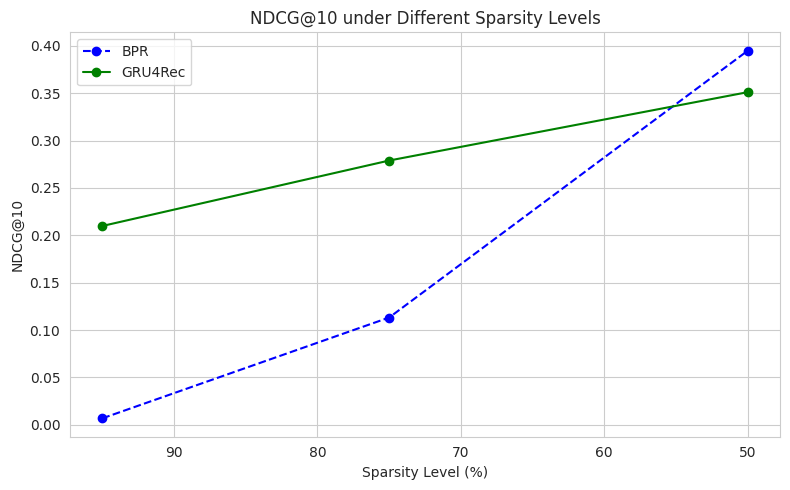

In [327]:
plt.figure(figsize=(8, 5))
plt.plot(df_sparsity_analysis['sparsity'], df_sparsity_analysis['BPR'], marker='o', label='BPR', linestyle='--', color='blue')
plt.plot(df_sparsity_analysis['sparsity'], df_sparsity_analysis['GRU4Rec'], marker='o', label='GRU4Rec', linestyle='-', color='green')

plt.xlabel('Sparsity Level (%)')
plt.ylabel('NDCG@10')
plt.title('NDCG@10 under Different Sparsity Levels')
plt.gca().invert_xaxis()  # Optional: higher sparsity on the left (more intuitive)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Cold Start Experiment

In [329]:
PREDICTION_PATH = '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/goodbooks-10k/predictions'
all_predictions_bpr = pickle.load(open(f'{PREDICTION_PATH}/predictions_bpr_opt.pkl', 'rb'))
all_predictions_gru = pickle.load(open(f'{PREDICTION_PATH}/predictions_gru_opt.pkl', 'rb'))

In [373]:
DATA_PATH = '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/goodbooks-10k/data_sample_split/'
train_data = pd.read_csv(f'{DATA_PATH}/data_train_full.tsv', sep='\t')
test_data = pd.read_csv(f'{DATA_PATH}/data_test.tsv', sep='\t')

In [347]:
all_predictions_bpr = all_predictions_bpr.sort_values(by=['user_id', 'prediction'], ascending=[True, False])
all_predictions_gru = all_predictions_gru.sort_values(by=['user_id', 'prediction'], ascending=[True, False])

In [353]:
filtered_df_gru = all_predictions_gru.merge(train_data, on=['user_id', 'book_id'], how='left', indicator=True)
filtered_df_gru = filtered_df_gru[filtered_df_gru['_merge'] == 'left_only']
filtered_df_gru = filtered_df_gru.drop(columns=['_merge'])

In [354]:
top10_bpr = all_predictions_bpr.groupby('user_id').head(10).reset_index(drop=True)
top10_gru = filtered_df_gru.groupby('user_id').head(10).reset_index(drop=True)

### Cold Start User

In [330]:
count_book_read_user = book_rating_filtered.groupby('user_id').agg({'book_id':'nunique', 'rating':'mean'})
count_book_read_user[["book_id"]].describe().T

,count,mean,std,min,25%,50%,75%,max
book_id,10000.0,57.8237,21.853791,20.0,41.0,56.0,72.0,158.0


In [357]:
len(count_book_read_user[count_book_read_user.book_id == 20])

60

In [457]:
user_cold_start = count_book_read_user[count_book_read_user.book_id == 20].index

In [458]:
predition_user_cs_bpr = top10_bpr[top10_bpr.user_id.isin(user_cold_start)]
predition_user_cs_gru = top10_gru[top10_gru.user_id.isin(user_cold_start)]

In [459]:
test_data_sample_cs = test_data[test_data.user_id.isin(user_cold_start)]

In [ ]:
test_data_sample_cs['user_id'] = test_data_sample_cs['user_id'].astype(str)
test_data_sample_cs['book_id'] = test_data_sample_cs['book_id'].astype(str)

predition_user_cs_bpr['user_id'] = predition_user_cs_bpr['user_id'].astype(str)
predition_user_cs_bpr['book_id'] = predition_user_cs_bpr['book_id'].astype(str)

predition_user_cs_gru['user_id'] = predition_user_cs_gru['user_id'].astype(str)
predition_user_cs_gru['book_id'] = predition_user_cs_gru['book_id'].astype(str)
predition_user_cs_gru['prediction'] = predition_user_cs_gru['prediction'].astype(float)

In [461]:
qrels_cs = Qrels.from_df(
    df=test_data_sample_cs,
    q_id_col="user_id",
    doc_id_col="book_id",
    score_col="rating",
  )

run_bpr_cs = Run.from_df(
    df=predition_user_cs_bpr,
    q_id_col="user_id",
    doc_id_col="book_id",
    score_col="prediction",
)

run_gru_cs = Run.from_df(
    df=predition_user_cs_gru,
    q_id_col="user_id",
    doc_id_col="book_id",
    score_col="prediction",
)

cold_start_metrics = {
  'BPR': evaluate(qrels_cs, run_bpr_cs, ["mrr", "ndcg@10", "recall@10", "precision@10", "hit_rate@10"], make_comparable=True),
  'GRU': evaluate(qrels_cs, run_gru_cs, ["mrr", "ndcg@10", "recall@10", "precision@10", "hit_rate@10"], make_comparable=True)}


In [462]:
pd.DataFrame(cold_start_metrics).T

,mrr,ndcg@10,recall@10,precision@10,hit_rate@10
BPR,0.220040,0.147279,0.175000,0.070000,0.416667
GRU,0.510602,0.362147,0.420833,0.168333,0.900000


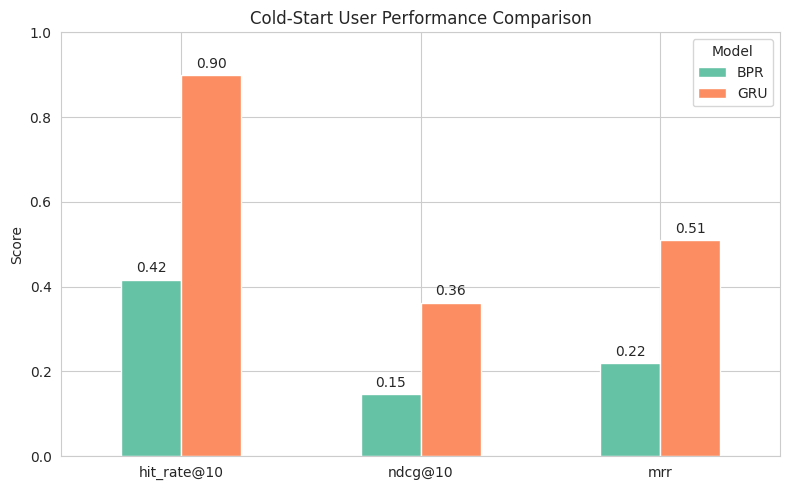

In [463]:
df_cold_user_metrics = pd.DataFrame(cold_start_metrics).T[['hit_rate@10', 'ndcg@10', 'mrr']]

ax = df_cold_user_metrics.T.plot(kind='bar', figsize=(8, 5), color=['#66c2a5', '#fc8d62'])

for container in ax.containers:
  ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.title('Cold-Start User Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

### Cold Start Items

In [381]:
count_user_in_book = book_rating_filtered.groupby('book_id').agg({'user_id':'nunique', 'rating':'mean'})
count_user_in_book[["user_id"]].describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,1000.0,578.237,530.405546,153.0,272.0,389.5,637.25,4400.0


In [383]:
len(count_user_in_book[count_user_in_book.user_id < 200])

14

In [389]:
book_cold_start = count_user_in_book[count_user_in_book.user_id < 200].index

In [396]:
book_cs_recommended_bpr = top10_bpr[top10_bpr.book_id.isin(book_cold_start)]
coverage_bpr = book_cs_recommended_bpr['user_id'].nunique() / top10_bpr['user_id'].nunique()
coverage_bpr

0.0385

In [397]:
book_cs_recommended_gru = top10_gru[top10_gru.book_id.isin(book_cold_start)]
coverage_gru = book_cs_recommended_gru['user_id'].nunique() / top10_gru['user_id'].nunique()
coverage_gru

0.055

In [409]:
user_get_recommended_cs_bpr = book_cs_recommended_bpr['user_id'].unique()
user_get_recommended_cs_gru = book_cs_recommended_gru['user_id'].unique()

In [410]:
test_data_rare_item_bpr = test_data[test_data.user_id.isin(user_get_recommended_cs_bpr)]
test_data_rare_item_bpr = test_data_rare_item_bpr.groupby('user_id').agg({'book_id': list}).reset_index()

test_data_rare_item_gru = test_data[test_data.user_id.isin(user_get_recommended_cs_gru)]
test_data_rare_item_gru = test_data_rare_item_gru.groupby('user_id').agg({'book_id': list}).reset_index()

In [418]:
recommended_rare_item_bpr = top10_bpr[top10_bpr.user_id.isin(user_get_recommended_cs_bpr)]
recommended_rare_item_bpr = recommended_rare_item_bpr.groupby('user_id').agg({'book_id': list}).reset_index()

recommended_rare_item_gru = top10_gru[top10_gru.user_id.isin(user_get_recommended_cs_gru)]
recommended_rare_item_gru = recommended_rare_item_gru.groupby('user_id').agg({'book_id': list}).reset_index()

In [437]:
497 in recommended_rare_item_bpr[recommended_rare_item_bpr.user_id == 53133]['book_id'].values[0]

True

In [442]:
hits_bpr = 0
for index, row in test_data_rare_item_bpr.iterrows():
  row_dict = row.to_dict()
  user_id = row_dict['user_id']
  if any(item in row_dict['book_id'] for item in recommended_rare_item_bpr[recommended_rare_item_bpr.user_id == user_id]['book_id'].values[0]):
    hits_bpr += 1

In [445]:
percentage_hits_bpr = hits_bpr/len(test_data_rare_item_bpr)
percentage_hits_bpr

0.6675324675324675

In [446]:
hits_gru = 0
for index, row in test_data_rare_item_gru.iterrows():
  row_dict = row.to_dict()
  user_id = row_dict['user_id']
  if any(item in row_dict['book_id'] for item in recommended_rare_item_gru[recommended_rare_item_gru.user_id == user_id]['book_id'].values[0]):
    hits_gru += 1

In [447]:
percentage_hits_gru = hits_bpr/len(test_data_rare_item_gru)
percentage_hits_gru

0.4672727272727273

In [448]:
cold_start_item_metrics = pd.DataFrame({
    'Metric': ['Coverage', 'Coverage', 'Hit Rate', 'Hit Rate'],
    'Model': ['BPR', 'GRU4Rec', 'BPR', 'GRU4Rec'],
    'Score': [coverage_bpr, coverage_gru, percentage_hits_bpr, percentage_hits_gru]
})

In [449]:
cold_start_item_metrics

,Metric,Model,Score
0,Coverage,BPR,0.038500
1,Coverage,GRU4Rec,0.055000
2,Hit Rate,BPR,0.667532
3,Hit Rate,GRU4Rec,0.467273


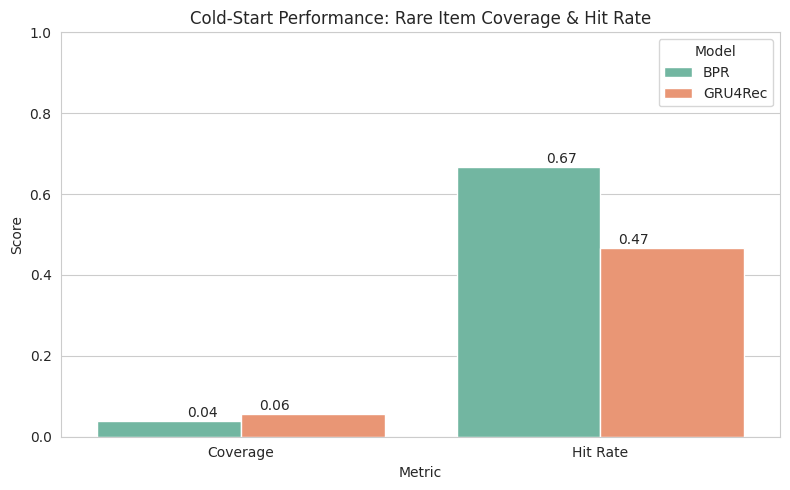

In [452]:
# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=cold_start_item_metrics, x='Metric', y='Score', hue='Model', palette='Set2')

# Add value labels on top of bars
for i in range(len(cold_start_item_metrics)):
    plt.text(
        x=i // 2 + (-0.15 if cold_start_item_metrics['Model'][i] == 'BPR' else 0.05),
        y=cold_start_item_metrics['Score'][i] + 0.01,
        s=f"{cold_start_item_metrics['Score'][i]:.2f}",
        fontsize=10
    )

plt.ylim(0, 1)
plt.title('Cold-Start Performance: Rare Item Coverage & Hit Rate')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.tight_layout()
plt.show()